<a href="https://colab.research.google.com/github/aravindv98/text_summarization_news_articles/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#### PRE PROCESSING #####
import kagglehub
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [12]:
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2


In [13]:
model_name = 'text_summarization'

data_train = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/train.csv")
data_test = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/test.csv")
data_validation = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/validation.csv")
print("Dataset loaded successfully.")


# Drop any rows with missing values (optional, based on data quality)
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)
data_validation.dropna(inplace=True)

Dataset loaded successfully.


In [14]:
data_train.iloc[0]

,0
id,0001d1afc246a7964130f43ae940af6bc6c57f01
article,By . Associated Press . PUBLISHED: . 14:11 EST...
highlights,"Bishop John Folda, of North Dakota, is taking ..."


In [15]:
print("The size of training data",len(data_train))
print("The size of testing data",len(data_test))
print("The size of validation data",len(data_validation))

The size of training data 287113
The size of testing data 11490
The size of validation data 13368


In [16]:
data_train['article_length'] = data_train['article'].str.len()
data_train['highlights_length'] = data_train['highlights'].str.len()

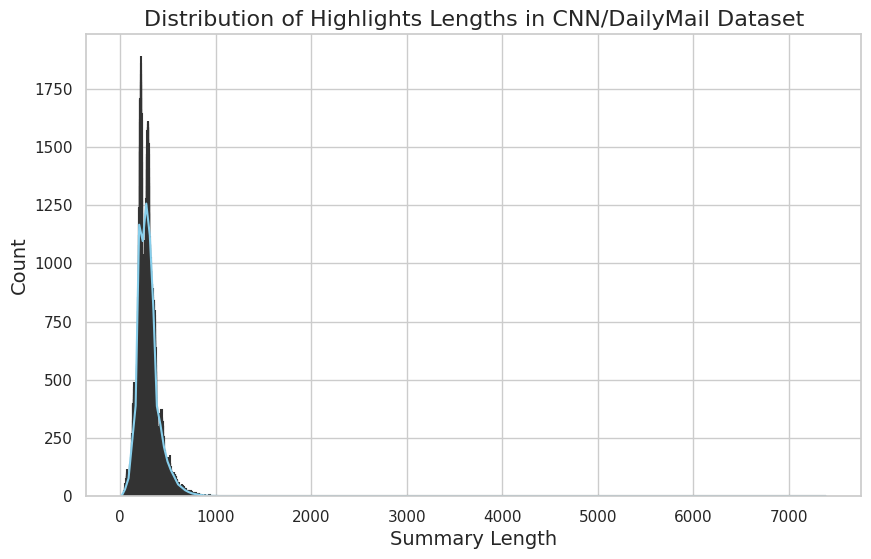

In [17]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create the histogram plot with Kernel Density Estimate (KDE)
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.histplot(data=data_train, x="highlights_length", kde=True, color="skyblue",
             binwidth=1, edgecolor=".2", linewidth=1.5)

plt.title('Distribution of Highlights Lengths in CNN/DailyMail Dataset', fontsize=16)
plt.xlabel('Summary Length', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()

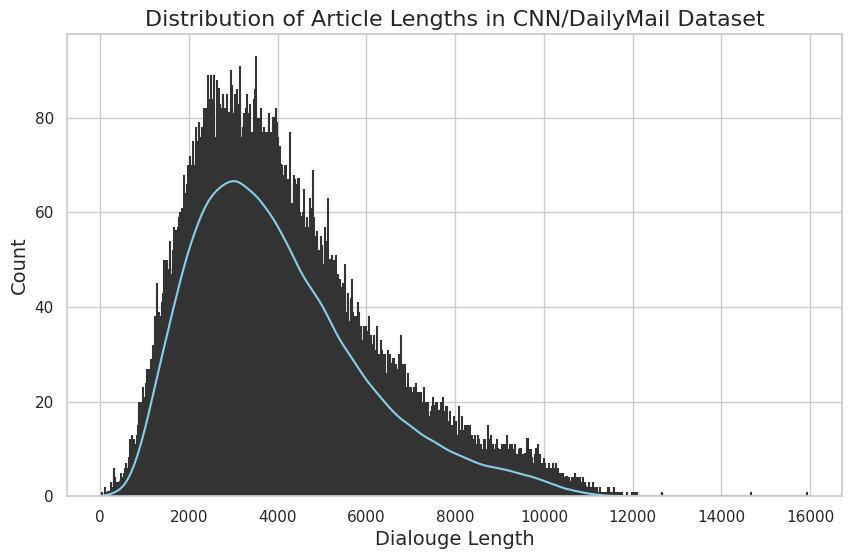

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create the histogram plot with Kernel Density Estimate (KDE)
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.histplot(data=data_train, x="article_length", kde=True, color="skyblue",
             binwidth=1, edgecolor=".2", linewidth=1.5)

# Add labels and title for clarity
plt.title('Distribution of Article Lengths in CNN/DailyMail Dataset', fontsize=16)
plt.xlabel('Dialouge Length', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()

In [ ]:

nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    return ' '.join(words)


data_train['cleaned_text'] = data_train['article'].apply(preprocess_text)
data_train['cleaned_summary'] = data_train['highlights'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Tokenization and converting text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train['cleaned_text'])

# Convert texts to sequences
max_text_len = 3000  # Define max length for text
max_summary_len = 600  # Define max length for summary

# Convert text and summaries to sequences and pad them
text_sequences = tokenizer.texts_to_sequences(data_train['cleaned_text'])
text_sequences = pad_sequences(text_sequences, maxlen=max_text_len, padding='post')

summary_sequences = tokenizer.texts_to_sequences(data_train['cleaned_summary'])
summary_sequences = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define constants
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for padding token)
embedding_dim = 100  # Dimension for word embedding (you can use pretrained embeddings, but we'll keep it simple here)
hidden_units = 256  # Number of hidden units in LSTM
max_text_len = 3000  # Maximum length of text sequences
max_summary_len = 600  # Maximum length of summary sequences

# Define the input sequence (article) and output sequence (summary)
encoder_input = Input(shape=(max_text_len,))

# Embedding layer for the article
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_text_len)(encoder_input)

# LSTM layer for the encoder
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# The encoder's final state will be passed as initial state for the decoder
encoder_states = [state_h, state_c]

# Decoder setup
decoder_input = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_summary_len)(decoder_input)

# LSTM layer for the decoder, using encoder's final states as initial states
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Output layer for the decoder (dense layer with softmax activation for classification)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_input, decoder_input], decoder_outputs)

# Compile the model with the Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()

# Now, you can train the model with the prepared data

# Prepare the decoder output for training
# We will shift the summary sequences by 1 for training the decoder (teacher forcing)
decoder_input_data = summary_sequences[:, :-1]  # All but the last word in the summary
decoder_output_data = summary_sequences[:, 1:]  # All but the first word in the summary (to match the decoder input)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    text_sequences, decoder_output_data, test_size=0.1, random_state=42)

# Train the model
history = model.fit(
    [X_train, decoder_input_data],
    np.expand_dims(y_train, -1),  # Decoder output should have an extra dimension for the class
    validation_data=([X_val, decoder_input_data], np.expand_dims(y_val, -1)),
    batch_size=64,
    epochs=10  # You can adjust the number of epochs based on your system
)

# Save the model (optional)
model.save('text_summarization_lstm.h5')


In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
# from tensorflow.keras.optimizers import Adam
# import numpy as np


# # Sampling a smaller subset for faster experimentation
# sampled_data = data.sample(frac=0.1, random_state=42)  # Use 10% of the dataset

# vocab_size = len(tokenizer.word_index) + 1

# # Tokenization and padding for the subset
# sampled_text_sequences = tokenizer.texts_to_sequences(sampled_data['cleaned_text'])
# sampled_text_sequences = pad_sequences(sampled_text_sequences, maxlen=max_text_len, padding='post')

# sampled_summary_sequences = tokenizer.texts_to_sequences(sampled_data['cleaned_summary'])
# sampled_summary_sequences = pad_sequences(sampled_summary_sequences, maxlen=max_summary_len, padding='post')

# # Train-validation split
# X_train, X_val, y_train, y_val = train_test_split(
#     sampled_text_sequences, sampled_summary_sequences, test_size=0.2, random_state=42
# )

# # Decoder input adjustment
# decoder_input_data = np.zeros_like(y_train)
# decoder_input_data[:, 1:] = y_train[:, :-1]

# decoder_input_val = np.zeros_like(y_val)
# decoder_input_val[:, 1:] = y_val[:, :-1]

# # Smaller model architecture for faster training
# embedding_dim = 50  # Reduced embedding dimension
# hidden_units = 128  # Reduced LSTM units

# # Encoder
# encoder_inputs = Input(shape=(max_text_len,))
# encoder_embedding = Embedding(vocab_size, embedding_dim, trainable=True)(encoder_inputs)
# encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
# encoder_states = [state_h, state_c]

# # Decoder
# decoder_inputs = Input(shape=(max_summary_len,))
# decoder_embedding = Embedding(vocab_size, embedding_dim, trainable=True)(decoder_inputs)
# decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# # Fully connected output layer
# decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_outputs)

# # Model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# # Training with reduced epochs
# history = model.fit(
#     [X_train, decoder_input_data],
#     np.expand_dims(y_train, -1),
#     epochs=10,
#     batch_size=32,  # Smaller batch size for quicker iterations
#     validation_data=([X_val, decoder_input_val], np.expand_dims(y_val, -1)),
#     verbose=1,
# )

# # Plotting training loss
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()



